# Imports
uses kerenel in /ihome/rbao/bri8/envs/r_seurat conda environment

In [33]:
suppressPackageStartupMessages({
    library(RColorBrewer)
    library(SpatialDecon)
    library(GeomxTools)
    library(dplyr)
    library(readxl)
    library(pheatmap)
    library(openxlsx)
    library(repr)
    library(ggpubr)
})
data <- file.path('.','local_data')
mif_samples <- read.csv(file.path(data,
                        'select_666nm_detections_dsp_comp_1_slide_2_4_6_FITC120_666nm1000.tsv'),
                        sep='\t') # extracted from DSP IF images
info <- read.csv(file.path(data, 'roi_annotation_list_v3.csv')) 
deconv_counts_fn <-  'q3_norm_for_deconv.xlsx'
dataset <-read_excel(file.path(data, deconv_counts_fn),
                     sheet='TargetCountMatrix') #no baseline subtraction
targets <- dataset$TargetName
dataset['TargetName'] <- NULL
dataset <- as.matrix(dataset)
rownames(dataset) <-targets
head(dataset,n=2)
segmentAnnotations <- read_excel(file.path(data, deconv_counts_fn),
                     sheet='SegmentProperties',
                    )
segmentAnnotations <- dplyr::left_join(segmentAnnotations, info[c('SegmentDisplayName', 'Condition','section')],'SegmentDisplayName')
targetAnnotations <- read_excel(file.path(data, deconv_counts_fn),
                     sheet='TargetProperties',
                    )

,collect slide 6 | 001 | Full ROI,collect slide 6 | 002 | Full ROI,collect slide 6 | 003 | Full ROI,collect slide 6 | 004 | Full ROI,collect slide 6 | 005 | Full ROI,collect slide 6 | 006 | Full ROI,collect slide 6 | 007 | Full ROI,collect slide 6 | 008 | Full ROI,collect slide 6 | 009 | Full ROI,collect slide 6 | 010 | Full ROI,⋯,collect slide 4 | 006 | Full ROI,collect slide 4 | 007 | Full ROI,collect slide 4 | 008 | Full ROI,collect slide 4 | 009 | Full ROI,collect slide 4 | 010 | Full ROI,collect slide 4 | 011 | Full ROI,collect slide 4 | 012 | Full ROI,collect slide 4 | 013 | Full ROI,collect slide 4 | 014 | Full ROI,collect slide 4 | 015 | Full ROI
RB1,31.63764,34.97747,22.50365,25.85227,21.46599,30.02030,27.61603,33.43164,34.44518,30.27542,⋯,35.88281,32.05517,16.98219,27.77977,27.34801,35.44078,25.12164,22.95377,23.93456,23.33118
GADD45G,37.83758,39.42622,25.06321,32.43603,25.14136,34.98721,32.30716,30.48845,43.55199,41.32337,⋯,41.37913,33.55556,17.82979,32.00455,34.73288,36.32686,23.62801,25.70446,28.12348,25.44247


# Get cell profile

In [32]:
matrixname = "ImmuneTumor_safeTME"
profile <- SpatialDecon::download_profile_matrix(species = "Human", age_group = "Adult", matrixname = matrixname)
head(profile,n=2)

,macrophages,mast,B.naive,B.memory,plasma,T.CD4.naive,T.CD4.memory,T.CD8.naive,T.CD8.memory,NK,pDCs,mDCs,monocytes.C,monocytes.NC.I,neutrophils,Treg,endothelial.cells,fibroblasts
A2M,0.853573886,0.04380881,0.004280745,0.001282789,0.0516385758,0.03949457,0.23911752,0.01596718,0.47688095,0.1658539,8.395752e-03,6.850967e-02,6.120532e-03,0.011250083,1.750109e-07,0.094505596,17.623008,11.036130608
ABCB1,0.002134372,0.02306899,0.025326570,0.005147731,0.0003317473,0.01120448,0.03233542,0.04699691,0.06524139,0.1698373,3.399479e-05,8.955508e-06,3.952379e-07,0.003160602,1.130183e-04,0.007394959,0.211153,0.006325604


# SpatialDecon on counts

In [27]:
# spatial decon function
#### preliminaries ----------------------
save = FALSE
pure_tumor_column_name <- "none"

# access cell profile matrix file:
X <- as.matrix(profile)
merges <- list()

# parse merges:
mergesFull <- NULL
if (length(merges) > 0) {
    # initialize with 1:1 mapping:
    mergesFull <- list()
    for (name in colnames(X)) {
      mergesFull[[name]] <- name
    }
    # add merges:
    for (name in names(merges)) {
      # remove entries for cells specified by user and replace with their entries:
      mergesFull[merges[[name]]] <- NULL
      mergesFull[[name]] <- merges[[name]]
    }
}


# ARGUMENT (hidden): enter the name of the column giving nuclei counts
nuclei_count_column_name <- "this_is_hidden_for_advanced_users" # "AOINucleiCount"

# parse nuclei column
cell_counts <- NULL
if (is.element(nuclei_count_column_name, colnames(segmentAnnotations))) {
    cell_counts <- as.numeric(segmentAnnotations[, nuclei_count_column_name])
}

# parse pure tumor column
is_pure_tumor <- NULL
if (is.element(pure_tumor_column_name, colnames(segmentAnnotations))) {
    is_pure_tumor <- tolower(segmentAnnotations[, pure_tumor_column_name]) == "tumor"
    is_pure_tumor <- replace(is_pure_tumor, is.na(is_pure_tumor), FALSE)
}
if (!is.element(pure_tumor_column_name, colnames(segmentAnnotations)) & (pure_tumor_column_name != "none")) {
    warning("The value entered for pure_tumor_column_name was not a column header in the segment annotations.")
}

# format data for spatialdecon:
norm <- dataset
if (all(is.element(c("ScanName", "ROIName", "SegmentName"), colnames(segmentAnnotations)))) {
    segmentAnnotations <- mutate(segmentAnnotations,
      segmentDisplayName = paste(ScanName, ROIName, SegmentName, sep = " | ")
    )
    if (all(!duplicated(segmentAnnotations$segmentDisplayName))) {
      colnames(norm) <- segmentAnnotations$segmentDisplayName
      rownames(segmentAnnotations) <- segmentAnnotations$segmentDisplayName
    }
}

# calculate background:
bg <- derive_GeoMx_background(
    norm = norm,
    probepool = targetAnnotations$ProbePool,
    negnames = targetAnnotations$TargetName[targetAnnotations$CodeClass == "Negative"]
)



#### run decon: ----------------------------------------
# decon:
res <- spatialdecon(
    norm = norm,
    bg = bg,
    X = X,
    is_pure_tumor = is_pure_tumor,
    cell_counts = cell_counts,
    cellmerges = mergesFull
)


#### write results files: ---------------------------------------------

  # initialize a workbook to write to excel:
  wb <- createWorkbook("decon")
  # write beta:
  addWorksheet(wb, "Abundance scores")
  writeData(wb,
    sheet = "Abundance scores",
    res$beta,
    colNames = TRUE, rowNames = TRUE
  )
  # write props:
  addWorksheet(wb, "Proportions")
  writeData(wb,
    sheet = "Proportions",
    res$prop_of_all,
    colNames = TRUE, rowNames = TRUE
  )
  # write scaled beta:
  addWorksheet(wb, "Scaled abundance scores")
  writeData(wb,
    sheet = "Scaled abundance scores",
    sweep(res$beta, 1, pmax(apply(res$beta, 1, max), min(res$beta[res$beta > 0])), "/"),
    colNames = TRUE, rowNames = TRUE
  )

  # write cell counts if available:
  if (is.element("cell.counts", names(res))) {
    addWorksheet(wb, "Cell counts")
    writeData(wb,
      sheet = "Cell counts",
      res$cell.counts$cell.counts,
      colNames = TRUE, rowNames = TRUE
    )
  }
  # add segment annotations:
  addWorksheet(wb, "Segment annotations")
  writeData(wb,
    sheet = "Segment annotations",
    segmentAnnotations,
    colNames = TRUE, rowNames = FALSE
  )

  if (save == TRUE){
      # save the excel workbook:
      saveWorkbook(wb,
        file = file.path('/mnt/results/', paste0(matrixname,".spatialdecon.URMC_01_Q3_HK_Norm_NoFilt_BI.xlsx"), fsep = .Platform$file.sep),
        overwrite = TRUE
      )
  }
print('Finished')

[1] "Finished"


# Plot heatmap 

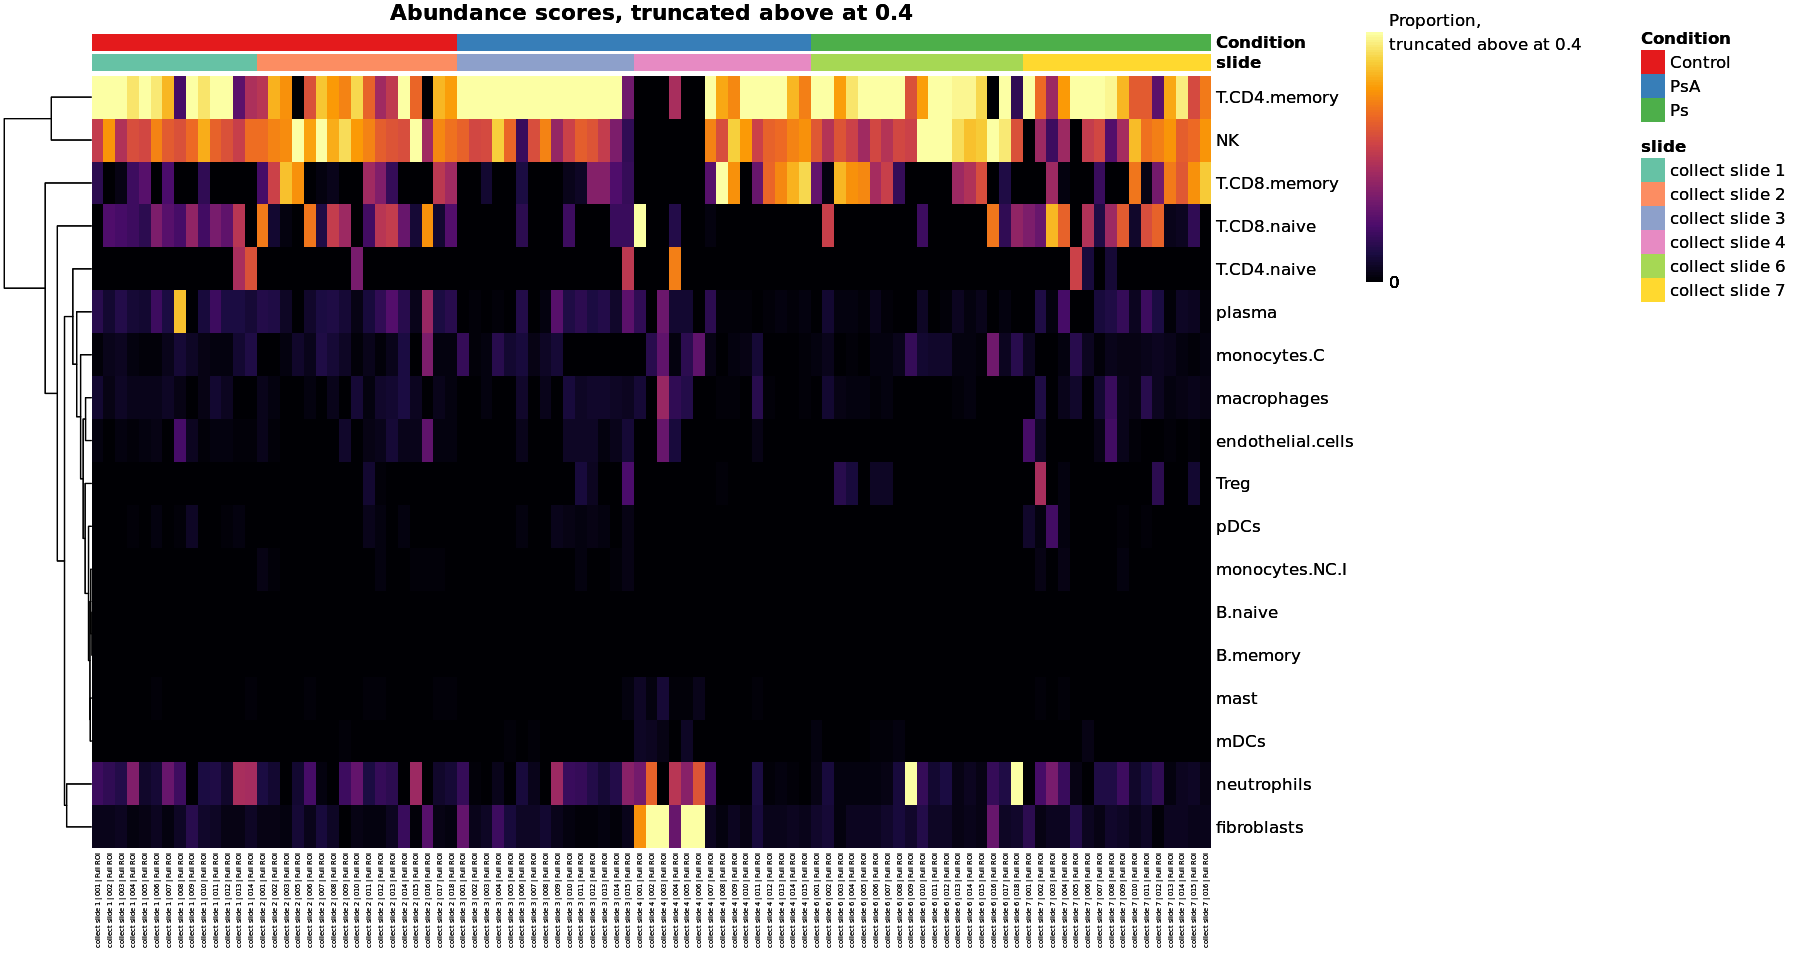

In [28]:
  #### heatmaps
  # abundances:
options(repr.plot.width=15, repr.plot.height=8)
variables_to_plot <- c('Condition','ScanLabel')
variables_to_plot <- intersect(variables_to_plot, colnames(segmentAnnotations))
heatmapanno <-as.data.frame(segmentAnnotations[,variables_to_plot,drop = FALSE])
rownames(heatmapanno) <- segmentAnnotations$SegmentDisplayName
heatmapanno <- heatmapanno[order(row.names(heatmapanno)),, drop=FALSE]
heatmapanno$slide <- heatmapanno$ScanLabel
heatmapanno$ScanLabel <- NULL
heatmapanno <- heatmapanno[,c(2,1)]
mat_colors <- list(Condition = brewer.pal(3, "Set1"))
mat_colors$slide = brewer.pal(length(unique(heatmapanno$slide)), "Set2")
names(mat_colors$Condition) <- unique(heatmapanno$Condition)
names(mat_colors$slide) <- unique(heatmapanno$slide)


# heatmapanno <- heatmapanno[colnames(res$prop_of_nontumor),]           
dat = res$prop_of_nontumor[,rownames(heatmapanno)]
use_cells = rownames(res$beta) #use all
# use_cells = c('T.CD4.memory','NK','T.CD8.memory','T.CD8.naive','macrophages','neutrophils','fibroblasts')
thresh <- signif(quantile(res$prop_of_nontumor, 0.97), 2)
hmcols = c("#000004FF", "#1B0C42FF", "#4B0C6BFF", "#781C6DFF", "#A52C60FF", "#CF4446FF", "#ED6925FF", "#FB9A06FF", "#F7D03CFF", "#FCFFA4FF")

p1 <- pheatmap(pmin(dat[use_cells,], thresh),
    col = colorRampPalette(hmcols)(100),
    # scale = 'row',
    fontsize_col = 4,
    angle_col = 90,
    annotation_col = heatmapanno,
    annotation_colors = mat_colors,
    cluster_cols = FALSE,
    # cluster_rows = FALSE,
    legend_breaks = c(round(seq(0, thresh, length.out = 5))[-5], thresh),
    legend_labels = c(round(seq(0, thresh, length.out = 5))[-5], paste0("Proportion,\ntruncated above at ", thresh)),
    main = paste0("Abundance scores, truncated above at ", thresh)
  )
p1


# Calc CD8+ mif proportion from QuPath annotations (manual)

In [29]:
#For each slide and ROI calculate proportion of positive slides
# almost this: out <- mif_samples %>% group_by(Image,Parent,Class) %>% summarise(count=n())
slides = unique(mif_samples[,'Image'])
df = data.frame()
i = 1
for (slide in slides){
    #For each ROI in slide:
    idx = mif_samples$Image %in% slide
    rois = unique(mif_samples$Parent[idx])
    # print(rois)
    for (roi in rois){
        #Calculate proportion CD8+
        idx2 = idx & (mif_samples$Parent %in% roi)
        neg = sum(mif_samples$Class[idx2] %in% 'Negative')
        pos = sum(mif_samples$Class[idx2] %in% 'Positive')
        col = sprintf('%s | %03.0f | Full ROI', substr(slide,1,15), roi)
        df[i,'image'] = col
        df[i,'mif_prop_CD8'] = pos / (pos + neg)
        i = i + 1
    }
    }
row.names(df) <- df$image
df$image <- NULL

#Merge with deconvolution data:
dat2 = t(res$prop_of_all)
if (matrixname == 'ImmuneCensus_HCA'){
    use_cols =c('cytotoxic.T.cell.type.1',
                'cytotoxic.T.cell.type.2',
                'naive.CD8+.T.cell')
    cd8_pos <- dat2[,use_cols[1]] + dat2[,use_cols[2]] + dat2[,use_cols[3]]
    deconv_info <- merge(df,cd8_pos, by='row.names')
}else{
    use_col1 = 'T.CD8.memory'
    use_col2 = 'T.CD8.naive'
    cd8_pos <- dat2[,use_col1] + dat2[,use_col2] 
    deconv_info <- merge(df,cd8_pos, by='row.names')

}
deconv_info$T.CD8.memory <- deconv_info$y
deconv_info$y <- NULL
row.names(deconv_info) <- deconv_info$Row.names
deconv_info$Row.names <- NULL

head(deconv_info)


,mif_prop_CD8,T.CD8.memory
,<dbl>,<dbl>
collect slide 2 | 001 | Full ROI,0.5280374,0.3670656
collect slide 2 | 002 | Full ROI,0.3627049,0.2532533
collect slide 2 | 003 | Full ROI,0.5407524,0.3492415
collect slide 2 | 005 | Full ROI,0.2703583,0.3004594
collect slide 2 | 006 | Full ROI,0.2946860,0.2779957
collect slide 2 | 009 | Full ROI,0.7884615,0.1714138


# Plot scatter of CD8+ from mif with cytotoxic.T estimated via deconvolution

`geom_smooth()` using formula = 'y ~ x'


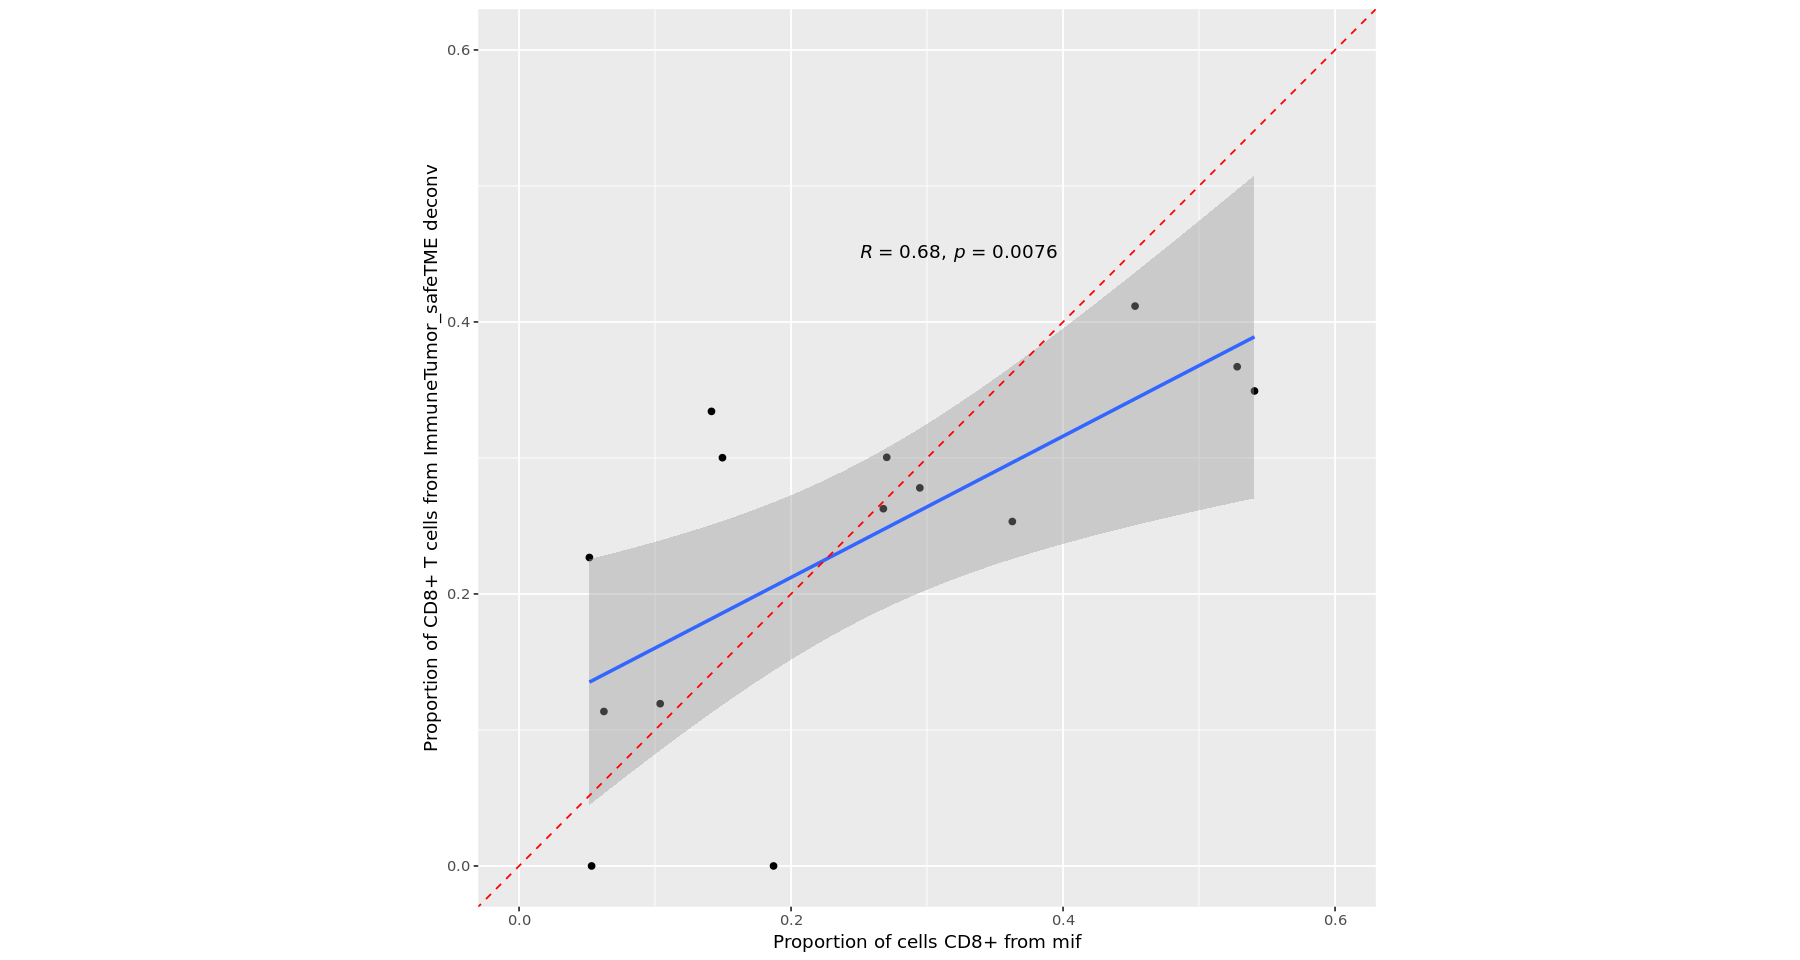

In [30]:
options(warn = -1)
exc =  exc =c('collect slide 4 | 001 | Full ROI')
use <- deconv_info[!(row.names(deconv_info) %in% exc),]
p1 <-ggplot(use, aes(x=mif_prop_CD8, y=T.CD8.memory)) +
     geom_point() + 
    geom_smooth(method=lm) +
    geom_abline(intercept = 0, slope=1, linetype = "dashed",color='red') + 
    stat_cor(method = "pearson", label.x = 0.25, label.y = 0.45)
p1 + labs(x = 'Proportion of cells CD8+ from mif',
          y = sprintf('Proportion of CD8+ T cells from %s deconv', matrixname),
          ) +
    xlim(c(0,0.6)) + 
    ylim(c(0,0.6)) +
   coord_fixed()